In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('data/fraud_oracle_processed.csv')

In [32]:
df.head()

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent
0,0,Dec,5,Wednesday,Honda,Urban,Tuesday,1,0,21,...,2,3,1994,Liability,False,True,False,1,0,15179
1,1,Jan,3,Wednesday,Honda,Urban,Monday,4,1,34,...,0,1,1994,Collision,False,True,False,1,0,15179
2,2,Oct,5,Friday,Honda,Urban,Thursday,2,1,47,...,0,1,1994,Collision,True,False,False,11,0,15179
3,3,Jun,2,Saturday,Toyota,Rural,Friday,1,1,65,...,0,1,1994,Liability,True,False,False,7,0,15179
4,4,Jan,5,Monday,Honda,Urban,Tuesday,2,0,27,...,0,1,1994,Collision,False,True,False,2,0,15179


## Touch up on data cleaning for Feature Importance Ranking


In [33]:
# Remove index column
df = df.iloc[:, 1:]

In [34]:
# Remove one row with DayOfWeekClaimed = 0 and MonthClaimed = 0
df = df.loc[~((df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0'))]

In [35]:
# Reorder the columns such that PolicyNumber is first
cols = df.columns.tolist()         # get the current column order
cols.remove('PolicyNumber')         # remove 'PolicyNumber' from its current position
df = df[['PolicyNumber'] + cols]     # reassemble the DataFrame with 'PolicyNumber' as the first column

In [46]:
# Convert dummy variables to a single MaritalStatus column
df['MaritalStatus'] = df.filter(regex = '^MaritalStatus_').idxmax(axis = 1)
df['MaritalStatus'] = df['MaritalStatus'].str.replace('MaritalStatus_', '')
df.drop(['MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow'], axis = 1, inplace = True)

In [55]:
# Mappings for numerical df

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

day_mapping = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}

area_mapping = {
    'Rural': 0, 'Urban': 1
}

fault_mapping = {
    'Policy Holder': 0, 'Third Party': 1
}

vtype_mapping = {
    'Sedan': 1, 'Sport': 2, 'Utility': 3
}

basepol_mapping = {
    'Collision': 1, 'Liability': 2, 'All Perils': 3
}

ptype_mapping = {}
for vtype, v_val in vtype_mapping.items():
    for basepol, bp_val in basepol_mapping.items():
        key = f'{vtype} - {basepol}'
        ptype_mapping[key] = v_val * 10 + bp_val

mstatus_mapping = {
    'Single': 0, 'Married': 1, 'Widow': 2
}

extra_mappings = {
    'Month': month_mapping,
    'DayOfWeek': day_mapping,
    'DayOfWeekClaimed': day_mapping,
    'AccidentArea': area_mapping,
    'Fault': fault_mapping,
    'VehicleCategory': vtype_mapping,
    'BasePolicy': basepol_mapping,
    'PolicyType': ptype_mapping,
    'MaritalStatus': mstatus_mapping
}

In [79]:
# Convert categorical variables to numerical in numeric df
numeric_df = df.copy()
for col, mapping in extra_mappings.items():
    numeric_df[col] = numeric_df[col].map(mapping)

In [80]:
# Remove Make(car brand) column as VehiclePrice provides more/same value as car brand and car brand is categorical
numeric_df.drop(['Make'], axis = 1, inplace = True)

In [81]:
# Create a column called DaysBetween to get the number of days between accident and claim 
# Assumption: all record in this dataset are within the same year
# Compute a rough day-of-year approximation for accident and claim dates.
numeric_df['accident_day'] = (numeric_df['Month'] - 1) * 30 + (numeric_df['WeekOfMonth'] - 1) * 7 + numeric_df['DayOfWeek']
numeric_df['claim_day'] = (numeric_df['MonthClaimed'] - 1) * 30 + (numeric_df['WeekOfMonthClaimed'] - 1) * 7 + numeric_df['DayOfWeekClaimed']
numeric_df['DaysBetween'] = numeric_df['claim_day'] - numeric_df['accident_day']
numeric_df.drop(['accident_day', 'claim_day'], axis = 1, inplace = True)

In [82]:
# Reordering columns for easier visualization
cols = numeric_df.columns.tolist()         
cols.remove("MonthClaimed")   
cols.remove("WeekOfMonthClaimed")
idx = cols.index("DayOfWeekClaimed")
cols.insert(idx, "WeekOfMonthClaimed") 
cols.insert(idx, "MonthClaimed") 
numeric_df = numeric_df[cols]

In [84]:
#very weird cause got some negative (can help me take a look lol)
#i mean if 12 to 1 then maybe is following year but some is like same month and week but day claimed is before day accident idk
numeric_df[numeric_df['DaysBetween'] < 0]

,PolicyNumber,Month,WeekOfMonth,DayOfWeek,AccidentArea,MonthClaimed,WeekOfMonthClaimed,DayOfWeekClaimed,Sex,Age,...,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,UnusualDeductible,ClaimsPerAgent,MaritalStatus,DaysBetween
0,1,12,5,3,1,1,1,2,0,21,...,0,0,2,3,1994,2,0,15179,0,-359
7,8,11,1,5,1,3,4,2,1,0,...,0,0,0,1,1994,1,0,15179,0,-222
17,18,7,5,7,1,8,1,3,0,28,...,0,1,0,1,1994,1,0,15179,1,-2
21,22,1,2,6,1,1,2,1,1,47,...,0,0,4,2,1994,1,0,15179,1,-5
23,24,6,3,6,1,6,3,2,1,31,...,0,3,0,1,1994,2,0,15179,0,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15398,15399,1,2,7,1,1,2,2,1,27,...,0,0,0,1,1996,2,0,15179,0,-5
15399,15400,1,2,7,1,1,2,3,1,39,...,0,0,0,1,1996,3,0,15179,1,-4
15400,15401,1,2,7,1,1,2,1,1,26,...,0,0,0,1,1996,3,0,15179,0,-6
15413,15414,11,4,4,1,11,4,1,1,40,...,0,1,0,1,1996,2,0,15179,1,-3


In [85]:
# Now all values are numeric and ready for RandomForrest
all_numeric = all(np.issubdtype(dtype, np.number) for dtype in numeric_df.dtypes)
print(all_numeric)

True


## Overview of value counts

In [87]:
for col in numeric_df.columns:
    print(f"Value counts for {col}:")
    print(numeric_df[col].value_counts())
    print("\n")

Value counts for PolicyNumber:
PolicyNumber
1        1
10361    1
10273    1
10274    1
10275    1
        ..
5146     1
5147     1
5148     1
5149     1
15420    1
Name: count, Length: 15419, dtype: int64


Value counts for Month:
Month
1     1411
5     1367
3     1360
6     1321
10    1305
12    1285
4     1280
2     1266
7     1256
9     1240
11    1201
8     1127
Name: count, dtype: int64


Value counts for WeekOfMonth:
WeekOfMonth
3    3640
2    3557
4    3398
1    3187
5    1637
Name: count, dtype: int64


Value counts for DayOfWeek:
DayOfWeek
1    2615
5    2445
2    2300
4    2173
3    2159
6    1982
7    1745
Name: count, dtype: int64


Value counts for AccidentArea:
AccidentArea
1    13822
0     1597
Name: count, dtype: int64


Value counts for MonthClaimed:
MonthClaimed
1     1446
5     1411
3     1348
10    1339
6     1293
2     1287
11    1285
4     1271
9     1242
7     1225
12    1146
8     1126
Name: count, dtype: int64


Value counts for WeekOfMonthClaimed:
WeekOfMonth

## Variables correlation heatmap

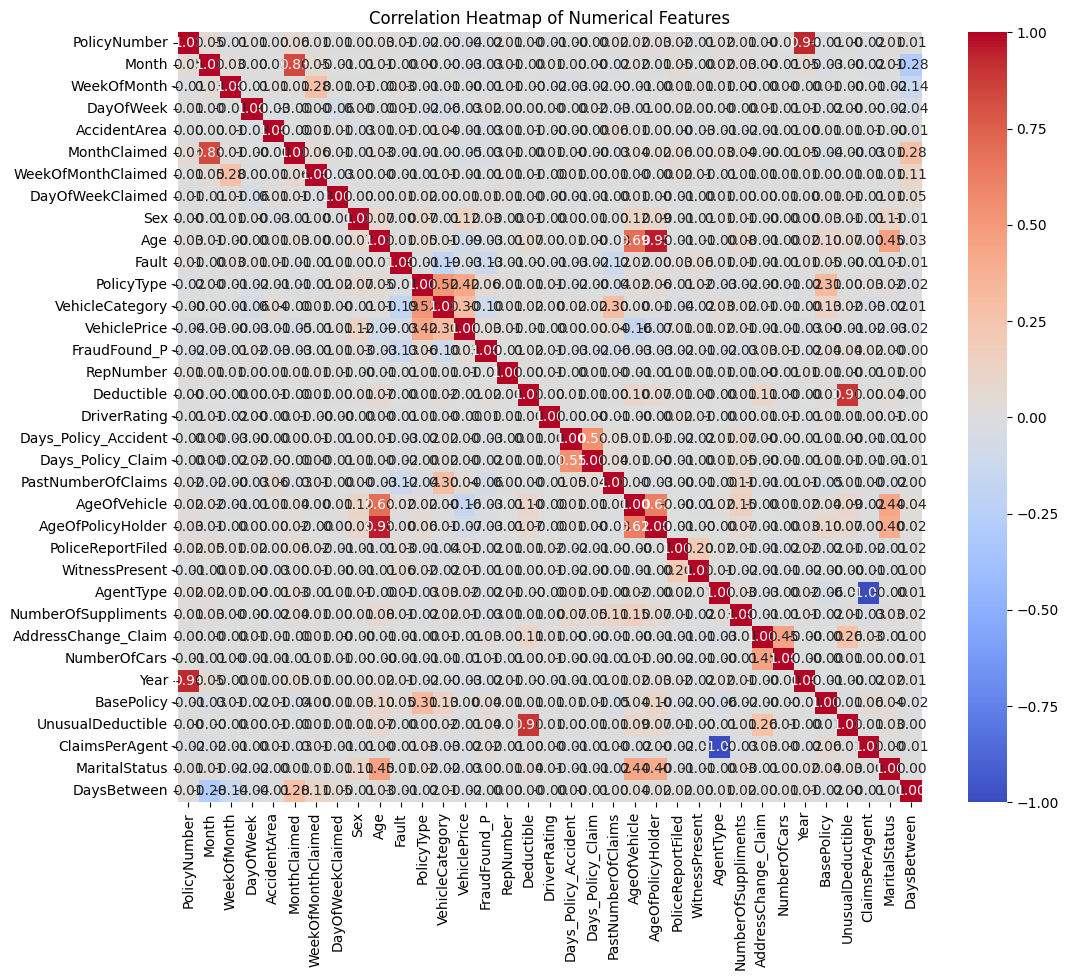

In [88]:
# Correlation heatmap
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Identifying significant variables

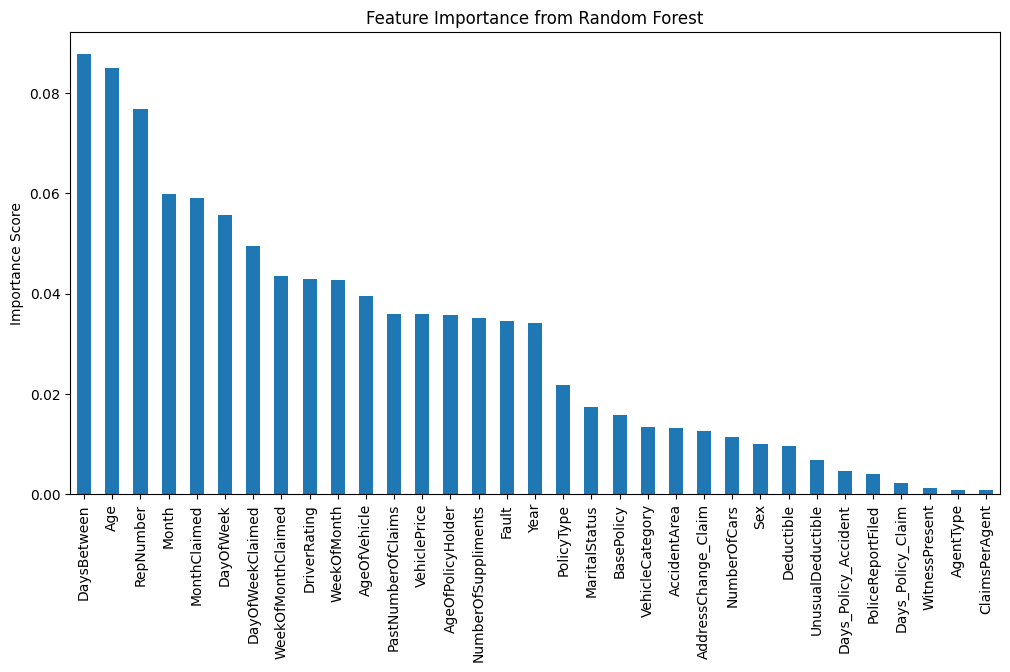

In [90]:
from sklearn.ensemble import RandomForestClassifier

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

rf = RandomForestClassifier(random_state=123)
rf.fit(X, y)
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importance.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()

## EDA Visualisation (Can do for top few important features)

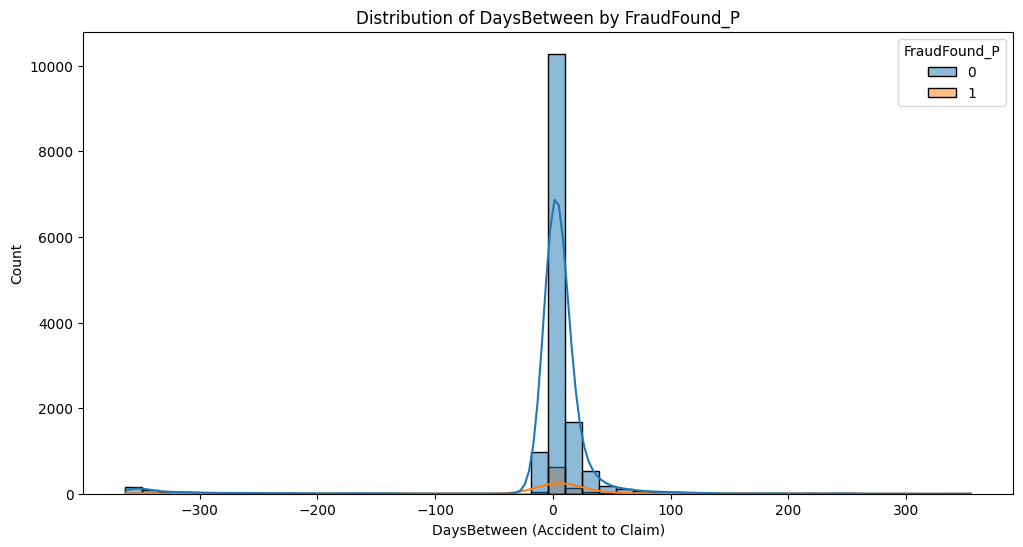

In [96]:
# Days Between
plt.figure(figsize=(12,6))
sns.histplot(data=numeric_df, x='DaysBetween', hue='FraudFound_P', bins=50, kde=True)
plt.title('Distribution of DaysBetween by FraudFound_P')
plt.xlabel('DaysBetween (Accident to Claim)')
plt.ylabel('Count')
plt.show()

C:\Users\teomi\AppData\Local\Temp\ipykernel_24408\1753859747.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')


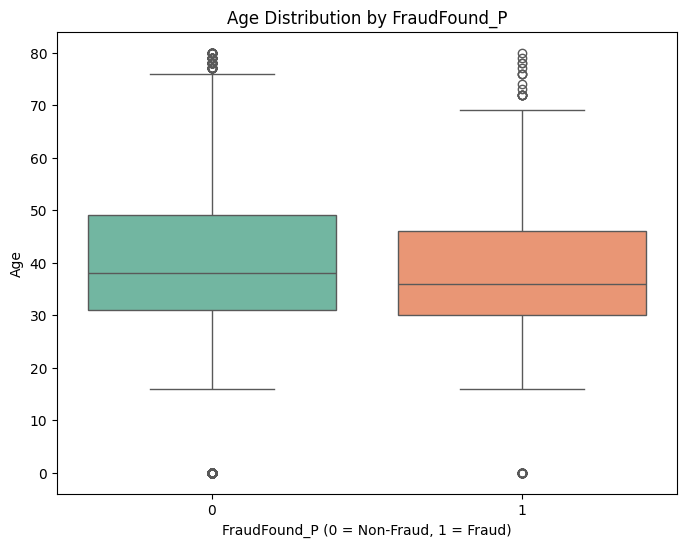

In [97]:
# Age
plt.figure(figsize=(8,6))
sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')
plt.title('Age Distribution by FraudFound_P')
plt.xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Age')
plt.show()

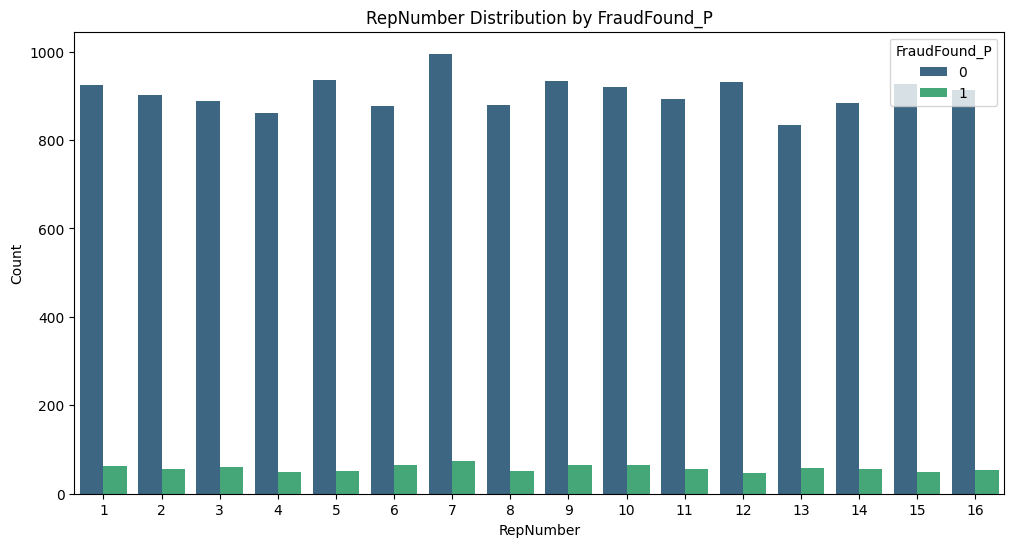

In [99]:
#RepNumber
plt.figure(figsize=(12,6))
sns.countplot(x='RepNumber', hue='FraudFound_P', data=df, palette='viridis')
plt.title('RepNumber Distribution by FraudFound_P')
plt.xlabel('RepNumber')
plt.ylabel('Count')
plt.show()

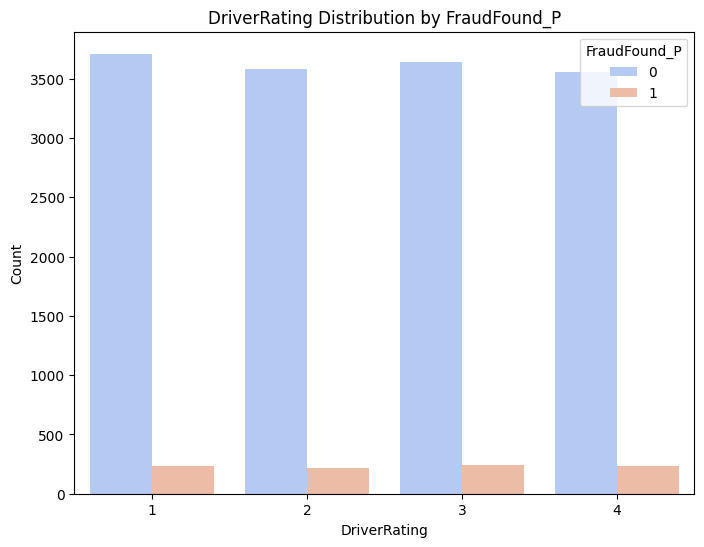

In [100]:
# Driver Rating
plt.figure(figsize=(8,6))
sns.countplot(x='DriverRating', hue='FraudFound_P', data=df, palette='coolwarm')
plt.title('DriverRating Distribution by FraudFound_P')
plt.xlabel('DriverRating')
plt.ylabel('Count')
plt.show()


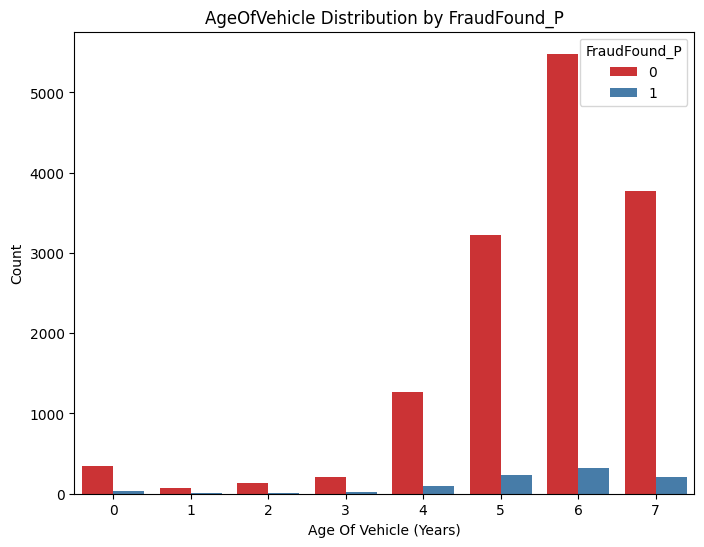

In [101]:
# AgeOfVehicle
plt.figure(figsize=(8,6))
sns.countplot(x='AgeOfVehicle', hue='FraudFound_P', data=df, palette='Set1')
plt.title('AgeOfVehicle Distribution by FraudFound_P')
plt.xlabel('Age Of Vehicle (Years)')
plt.ylabel('Count')
plt.show()

C:\Users\teomi\AppData\Local\Temp\ipykernel_24408\2099672381.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000'], rotation=45, ha='right')


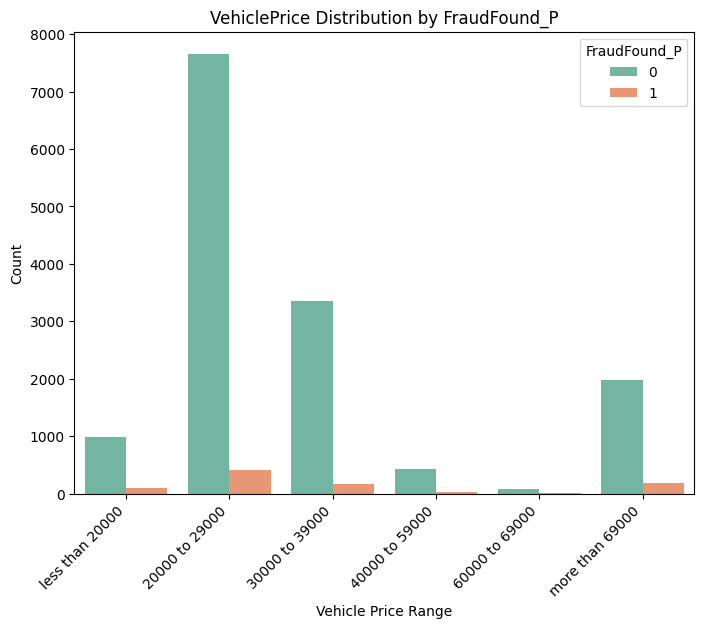

In [107]:
# VehiclePrice
plt.figure(figsize=(8,6))
g = sns.countplot(x='VehiclePrice', hue='FraudFound_P', data=numeric_df, palette='Set2')
plt.title('VehiclePrice Distribution by FraudFound_P')
plt.xlabel('Vehicle Price Range')
plt.ylabel('Count')
g.set_xticklabels(['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000'], rotation=45, ha='right')
plt.show()

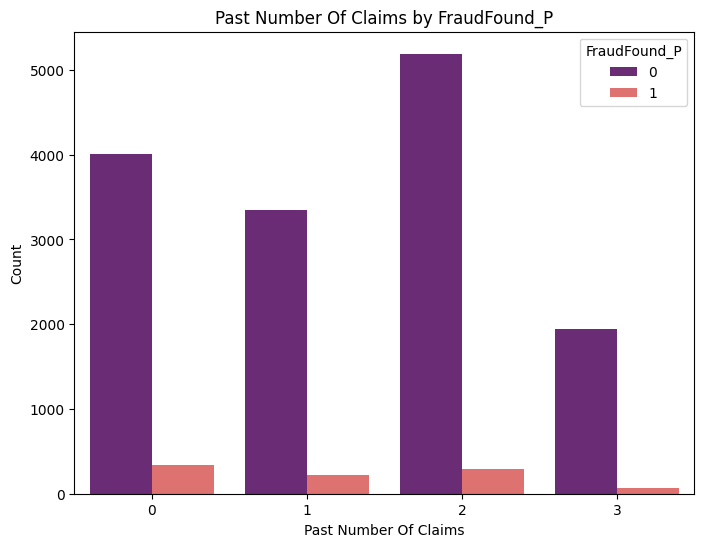

In [109]:
# Past number of claims
plt.figure(figsize=(8,6))
sns.countplot(x='PastNumberOfClaims', hue='FraudFound_P', data=numeric_df, palette='magma')
plt.title('Past Number Of Claims by FraudFound_P')
plt.xlabel('Past Number Of Claims')
plt.ylabel('Count')
plt.show()

C:\Users\teomi\AppData\Local\Temp\ipykernel_24408\219336224.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Policy Holder', 'Third Party'], rotation=45, ha='right')


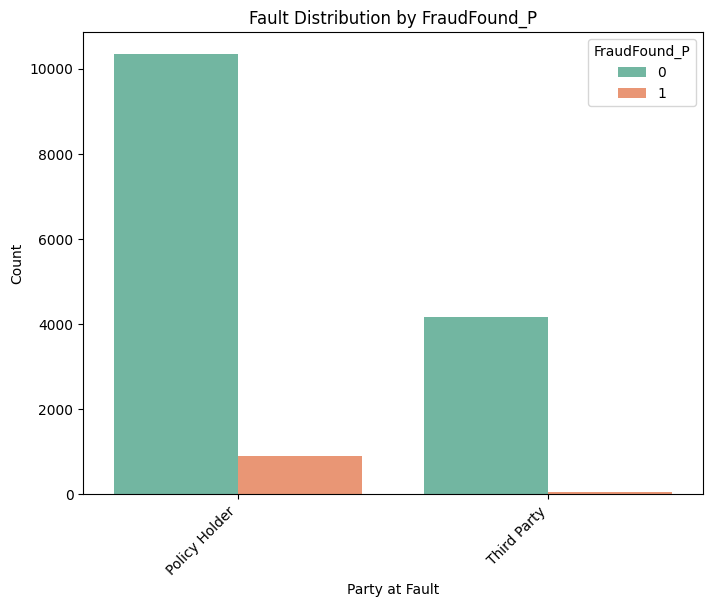

In [110]:
# Fault
plt.figure(figsize=(8,6))
g = sns.countplot(x='Fault', hue='FraudFound_P', data=numeric_df, palette='Set2')
plt.title('Fault Distribution by FraudFound_P')
plt.xlabel('Party at Fault')
plt.ylabel('Count')
g.set_xticklabels(['Policy Holder', 'Third Party'], rotation=45, ha='right')
plt.show()

## Sampling methods

In [93]:
# Oversampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming X and y have been defined and preprocessed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state=123)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4338
           1       0.13      0.12      0.13       288

    accuracy                           0.90      4626
   macro avg       0.54      0.53      0.54      4626
weighted avg       0.89      0.90      0.89      4626

